<a href="https://colab.research.google.com/github/dlgur1994/Hackerthon1_Aiffel/blob/main/jisu/Recruit_Restaurant_Visitor_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이 사이트의 예약, 방문 및 기타 정보를 사용하여 지정된 날짜에 미래의 레스토랑 방문자 합계를 예측해야 합니다. 교육 데이터는 <u>2016년부터 2017년 4월까지</u>를 포함합니다.        

테스트 세트는 <u>2017년 4월과 5월의 마지막 주</u>에 걸쳐 있습니다. 


테스트 세트는 시간(선착순, 일반에 이은 개인 폴더)에 따라 분할되며 선택된 일부 에어 레스토랑에 적용됩니다. 테스트 세트는 <u>의도적으로 "골든 위크"라고 불리는 일본의 휴일 주에 걸쳐 진행</u>됩니다."

시험장에서 식당이 문을 닫고 손님이 없는 날이 있다. 점수 매기기에서는 무시됩니다. 그 훈련 세트에는 식당들이 문을 닫은 날들이 생략되어 있다.

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [ ]:
air_res = pd.read_csv('/content/drive/MyDrive/Hackathon/recruit-restaurant-visitor-forecasting/air_reserve.csv.zip')
air_store = pd.read_csv('/content/drive/MyDrive/Hackathon/recruit-restaurant-visitor-forecasting/air_store_info.csv.zip')
hpg_res = pd.read_csv('/content/drive/MyDrive/Hackathon/recruit-restaurant-visitor-forecasting/hpg_reserve.csv.zip')
hpg_store = pd.read_csv('/content/drive/MyDrive/Hackathon/recruit-restaurant-visitor-forecasting/hpg_store_info.csv.zip')
air_visit = pd.read_csv('/content/drive/MyDrive/Hackathon/recruit-restaurant-visitor-forecasting/air_visit_data.csv.zip')
id_rel = pd.read_csv('/content/drive/MyDrive/Hackathon/recruit-restaurant-visitor-forecasting/store_id_relation.csv.zip')

In [ ]:
display(air_res.head())
air_res.info()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   air_store_id      92378 non-null  object
 1   visit_datetime    92378 non-null  object
 2   reserve_datetime  92378 non-null  object
 3   reserve_visitors  92378 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [ ]:
display(air_store.head())
air_store.info()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.69512,135.19785
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.69512,135.19785
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.69512,135.19785
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.69512,135.19785
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_store_id    829 non-null    object 
 1   air_genre_name  829 non-null    object 
 2   air_area_name   829 non-null    object 
 3   latitude        829 non-null    float64
 4   longitude       829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


In [ ]:
display(air_visit.head())
display(air_visit.info())
hpg_res.info()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   air_store_id  252108 non-null  object
 1   visit_date    252108 non-null  object
 2   visitors      252108 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 4 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   hpg_store_id      object
 1   visit_datetime    object
 2   reserve_datetime  object
 3   reserve_visitors  int64 
dtypes: int64(1), object(3)
memory usage: 61.0+ MB


In [ ]:
id_rel.head()
id_rel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   air_store_id  150 non-null    object
 1   hpg_store_id  150 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


In [ ]:
air_res.air_store_id.nunique() # nujmber of unique restaurants in air system

314

In [ ]:
hpg_res.hpg_store_id.nunique()

13325

In [ ]:
id_rel.air_store_id.nunique()

150

## Data Merging
: 데이터 전부를 합처 하나의 데이터를 만든다

In [ ]:
# Rename som columns before merging
# air_store.rename(columns={"air_genre_name": "genre_name", " B": "c"})

In [ ]:
# Merge tables
air = pd.merge(air_res, air_store, on='air_store_id')
hpg = pd.merge(hpg_res, hpg_store, on='hpg_store_id')

display(air.isnull().sum())
display(hpg.isnull().sum())
print('-------------------------------')
air_rel = pd.merge(air, id_rel, how='left', on='air_store_id')
hpg_rel = pd.merge(hpg, id_rel, how='left', on='hpg_store_id')

display(air_rel.isnull().sum())
display(hpg_rel.isnull().sum())
print('-------------------------------')
full = pd.merge(air_rel, hpg_rel, how='outer')

display(full.isnull().sum())

air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
air_genre_name      0
air_area_name       0
latitude            0
longitude           0
dtype: int64

hpg_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
hpg_genre_name      0
hpg_area_name       0
latitude            0
longitude           0
dtype: int64

-------------------------------


air_store_id            0
visit_datetime          0
reserve_datetime        0
reserve_visitors        0
air_genre_name          0
air_area_name           0
latitude                0
longitude               0
hpg_store_id        56114
dtype: int64

hpg_store_id             0
visit_datetime           0
reserve_datetime         0
reserve_visitors         0
hpg_genre_name           0
hpg_area_name            0
latitude                 0
longitude                0
air_store_id        857780
dtype: int64

-------------------------------


air_store_id        857780
visit_datetime           0
reserve_datetime         0
reserve_visitors         0
air_genre_name      871308
air_area_name       871308
latitude                 0
longitude                0
hpg_store_id         56114
hpg_genre_name       92378
hpg_area_name        92378
dtype: int64

In [ ]:
print("In air reservations are: %d \nIn hpg reservations are: %d \nIn both systems at once there are: %d" % \
      (air.shape[0], hpg.shape[0], id_rel.shape[0]))
print("So, totally must be: %d reservations." \
      % (full.shape[0]))

In air reservations are: 92378 
In hpg reservations are: 871308 
In both systems at once there are: 150
So, totally must be: 963686 reservations.


In [ ]:
# Then we need to convert columns 'visit_datetime' and 'reserve_datetime' from object type -> to data/time type
full['visit_datetime'] = pd.to_datetime(full['visit_datetime'])
full['reserve_datetime'] = pd.to_datetime(full['reserve_datetime'])
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 963686 entries, 0 to 963685
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   air_store_id      105906 non-null  object        
 1   visit_datetime    963686 non-null  datetime64[ns]
 2   reserve_datetime  963686 non-null  datetime64[ns]
 3   reserve_visitors  963686 non-null  int64         
 4   air_genre_name    92378 non-null   object        
 5   air_area_name     92378 non-null   object        
 6   latitude          963686 non-null  float64       
 7   longitude         963686 non-null  float64       
 8   hpg_store_id      907572 non-null  object        
 9   hpg_genre_name    871308 non-null  object        
 10  hpg_area_name     871308 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 88.2+ MB


## visit_datetime 과 reserve_datetime 을 년/월/일/주/시간 으로 나눈다

In [ ]:
# Split converted date-time columns to year, month, date, day of week and time separate coluns of dataset
full['visit_year'] = pd.Series(full.visit_datetime.dt.year)
full['visit_month']  = pd.Series(full.visit_datetime.dt.month)
full['visit_date'] = pd.Series(full.visit_datetime.dt.day)
full['visit_weekday'] = pd.Series(full.visit_datetime.dt.weekday)
full['visit_time'] = pd.Series(full.visit_datetime.dt.time)

In [ ]:
full['reserve_year'] = pd.Series(full.reserve_datetime.dt.year)
full['reserve_month']  = pd.Series(full.reserve_datetime.dt.month)
full['reserve_date'] = pd.Series(full.reserve_datetime.dt.day)
full['reserve_weekday'] = pd.Series(full.reserve_datetime.dt.weekday)
full['reserve_time'] = pd.Series(full.reserve_datetime.dt.time)

In [ ]:
full.info()
full.head(300)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 963686 entries, 0 to 963685
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   air_store_id      105906 non-null  object        
 1   visit_datetime    963686 non-null  datetime64[ns]
 2   reserve_datetime  963686 non-null  datetime64[ns]
 3   reserve_visitors  963686 non-null  int64         
 4   air_genre_name    92378 non-null   object        
 5   air_area_name     92378 non-null   object        
 6   latitude          963686 non-null  float64       
 7   longitude         963686 non-null  float64       
 8   hpg_store_id      907572 non-null  object        
 9   hpg_genre_name    871308 non-null  object        
 10  hpg_area_name     871308 non-null  object        
 11  visit_year        963686 non-null  int64         
 12  visit_month       963686 non-null  int64         
 13  visit_date        963686 non-null  int64         
 14  visi

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,visit_year,visit_month,visit_date,visit_weekday,visit_time,reserve_year,reserve_month,reserve_date,reserve_weekday,reserve_time
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,NaN,NaN,NaN,2016,1,1,4,19:00:00,2016,1,1,4,16:00:00
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,NaN,NaN,NaN,2016,1,1,4,20:00:00,2016,1,1,4,16:00:00
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,NaN,NaN,NaN,2016,1,2,5,18:00:00,2016,1,1,4,16:00:00
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,NaN,NaN,NaN,2016,1,2,5,21:00:00,2016,1,1,4,16:00:00
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,NaN,NaN,NaN,2016,1,8,4,21:00:00,2016,1,4,0,20:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,air_877f79706adbfb06,2016-04-12 21:00:00,2016-04-01 23:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,NaN,NaN,NaN,2016,4,12,1,21:00:00,2016,4,1,4,23:00:00
296,air_877f79706adbfb06,2016-04-12 21:00:00,2016-04-01 23:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,NaN,NaN,NaN,2016,4,12,1,21:00:00,2016,4,1,4,23:00:00
297,air_877f79706adbfb06,2016-04-12 21:00:00,2016-04-11 12:00:00,4,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,NaN,NaN,NaN,2016,4,12,1,21:00:00,2016,4,11,0,12:00:00
298,air_877f79706adbfb06,2016-04-13 21:00:00,2016-04-04 23:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,NaN,NaN,NaN,2016,4,13,2,21:00:00,2016,4,4,0,23:00:00


## 데이터를 합친 후 생긴 결측치를 채운다(기존 데이터에는 결측치 없었으나 합친 후 생김)

In [ ]:
display(full.shape)
full.isnull().sum()

(963686, 21)

air_store_id        857780
visit_datetime           0
reserve_datetime         0
reserve_visitors         0
air_genre_name      871308
air_area_name       871308
latitude                 0
longitude                0
hpg_store_id         56114
hpg_genre_name       92378
hpg_area_name        92378
visit_year               0
visit_month              0
visit_date               0
visit_weekday            0
visit_time               0
reserve_year             0
reserve_month            0
reserve_date             0
reserve_weekday          0
reserve_time             0
dtype: int64

In [ ]:
# 결측치를 채우자
full['air_store_id'] = full['air_store_id'].fillna('0')
full['hpg_store_id'] = full['hpg_store_id'].fillna('0')
full['air_genre_name'] = full['air_genre_name'].fillna('0')
full['hpg_genre_name'] = full['hpg_genre_name'].fillna('0')

In [ ]:
full.isnull().sum()
full.head(100)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,visit_year,visit_month,visit_date,visit_weekday,visit_time,reserve_year,reserve_month,reserve_date,reserve_weekday,reserve_time
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,0,0,NaN,2016,1,1,4,19:00:00,2016,1,1,4,16:00:00
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,0,0,NaN,2016,1,1,4,20:00:00,2016,1,1,4,16:00:00
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,0,0,NaN,2016,1,2,5,18:00:00,2016,1,1,4,16:00:00
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,0,0,NaN,2016,1,2,5,21:00:00,2016,1,1,4,16:00:00
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,0,0,NaN,2016,1,8,4,21:00:00,2016,1,4,0,20:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,air_877f79706adbfb06,2016-02-06 20:00:00,2016-02-05 17:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,0,0,NaN,2016,2,6,5,20:00:00,2016,2,5,4,17:00:00
96,air_877f79706adbfb06,2016-02-06 21:00:00,2016-02-06 21:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,0,0,NaN,2016,2,6,5,21:00:00,2016,2,6,5,21:00:00
97,air_877f79706adbfb06,2016-02-08 18:00:00,2016-01-19 12:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,0,0,NaN,2016,2,8,0,18:00:00,2016,1,19,1,12:00:00
98,air_877f79706adbfb06,2016-02-08 21:00:00,2016-01-14 13:00:00,4,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,0,0,NaN,2016,2,8,0,21:00:00,2016,1,14,3,13:00:00


In [ ]:
# Now lets put our data in order
# Create column 'store_id', where all ids from two sources will be collected together
full.loc[(full['air_genre_name'] != '0'), 'store_id'] = full['air_store_id']
full.loc[(full['air_genre_name'] == '0'), 'store_id'] = full['hpg_store_id']

# Create column 'store_genre_name', where all genres of restaurants will be collected together
full.loc[(full['air_genre_name'] != '0'), 'store_genre_name'] = full['air_genre_name']
full.loc[(full['air_genre_name'] == '0'), 'store_genre_name'] = full['hpg_genre_name']

# Create column 'air_hpg_link', to save connection between restaurants that are in both sources
full.loc[(full['air_store_id'] != '0') & (full['hpg_genre_name'] != '0'), 'air_hpg_link'] = full['air_store_id']
full.loc[(full['air_store_id'] != '0') & (full['hpg_genre_name'] == '0'), 'air_hpg_link'] = full['hpg_store_id']

# Create column 'store_genre_name', where all genres of restaurants will be collected together
full.loc[(full['air_genre_name'] != '0'), 'area_name'] = full['air_area_name']
full.loc[(full['air_genre_name'] == '0'), 'area_name'] = full['hpg_area_name']

full['air_hpg_link'] = full['air_hpg_link'].fillna('0')

In [ ]:
full['air_genre_name'].unique()

array(['Japanese food', 'Dining bar', 'Izakaya',
       'Okonomiyaki/Monja/Teppanyaki', 'Italian/French', 'Cafe/Sweets',
       'Yakiniku/Korean food', 'Western food', 'Bar/Cocktail', 'Other',
       'Creative cuisine', 'Karaoke/Party', 'International cuisine',
       'Asian', '0'], dtype=object)

## 시각화

id: air id+YYYY-mm-dd              
visitors: 예상되는 방문자의 수        
전체기간 예약자와 방문자수 추이                  
2016년 내 월별 방문자수 -> lineplot, barchart              
휴일일때 시간대별 방문자수             
휴일이 아닐 때 시간대별 방문자수           
예약자 수와 실제 방문자 수의 관계            
genre와 방문자 수의 관계          

## latitudem, longitude를 이용한 맵 시각화

In [ ]:
import folium

df = full.loc[:, ['air_store_id', 'air_genre_name', 'latitude', 'longitude']]
df = df.drop_duplicates()
df.reset_index(inplace=True)


#지도 띄우기 (지도의 중심을 지정하기 위해 위도와 경도의 평균 구하기)
map = folium.Map([df['latitude'].mean(),df['longitude'].mean()],zoom_start=9)

for i in df.index:
    sub_lat =  df.loc[i,'latitude']
    sub_long = df.loc[i,'longitude']
    
    title1 = df.loc[i, 'air_store_id']
    title2 = df.loc[i,'air_genre_name']
    #지도에 데이터 찍어서 보여주기
    folium.Marker([sub_lat,sub_long], popup = title+'\n'+title2).add_to(map)

#한글이 안나오는 오류로 html로 trouble shooting 
map.save('map.html')
map


우리는 레스토랑 방문 횟수를 계획하는 것으로 시각화를 시작합니다. 여기에서는 전체 교육 시간(2016년 1월부터 2017년 5월까지), 매월(1월) 및 매주(04.01.10.01.2016년 역시 휴일이 포함되지 않음) 동안의 총 방문자 수를 표시합니다.

,visit_datetime,air_store_id,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,visit_year,visit_month,visit_date,visit_weekday,visit_time,reserve_year,reserve_month,reserve_date,reserve_weekday,reserve_time,store_id,store_genre_name,air_hpg_link,area_name
0,2016-01-01 13:00:00,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2016-01-01 17:00:00,13,13,13,13,0,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
2,2016-01-01 18:00:00,25,25,25,25,0,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25
3,2016-01-01 19:00:00,35,35,35,35,3,35,35,35,35,32,35,35,35,35,35,35,35,35,35,35,35,35,35,35
4,2016-01-01 20:00:00,9,9,9,9,2,9,9,9,9,7,9,9,9,9,9,9,9,9,9,9,9,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8673,2017-05-31 18:00:00,8,8,8,8,0,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
8674,2017-05-31 19:00:00,5,5,5,5,0,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
8675,2017-05-31 20:00:00,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2
8676,2017-05-31 21:00:00,2,2,2,2,1,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2


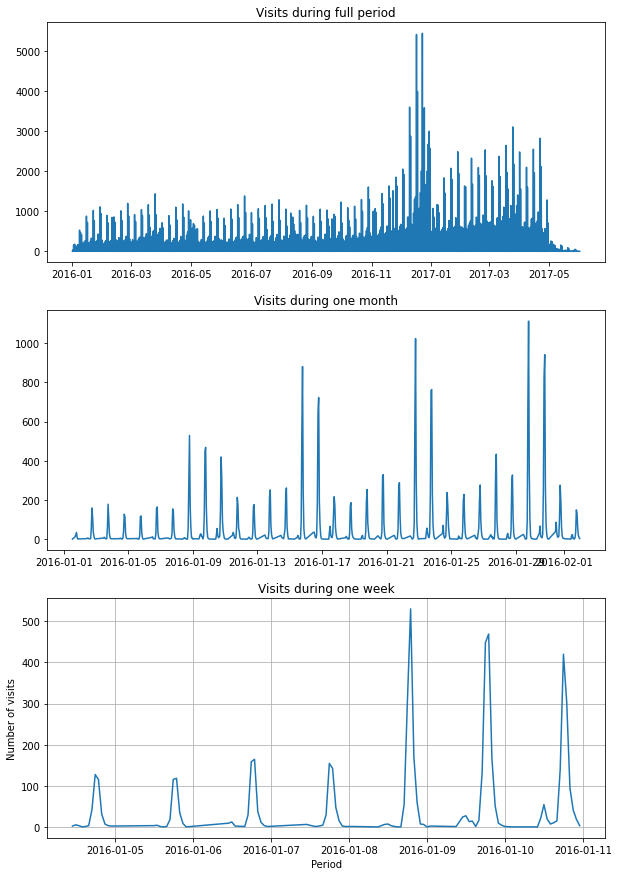

In [ ]:
fullhist = full.groupby(['visit_datetime'],as_index=False).count().sort_values(by=['visit_datetime']) # 방문 시간으로 방문자를 예측
display(fullhist)
fullhist_mnth = fullhist.loc[fullhist['visit_datetime'] <= pd.to_datetime('2016-02-01 23:59:00')]
fullhist_week = fullhist.loc[(fullhist['visit_datetime'] >= pd.to_datetime('2016-01-04 00:00:00')) \
                            & (fullhist['visit_datetime'] <= pd.to_datetime('2016-01-10 23:59:00'))]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,15))
#fig, ax1 = plt.subplots(1, 1, figsize=(10,10))
ax1.plot(fullhist.visit_datetime, fullhist.store_id)
ax1.set_title("Visits during full period")
plt.ylabel("Number of visits")
plt.grid(True)

ax2.plot(fullhist_mnth.visit_datetime, fullhist_mnth.store_id)
ax2.set_title("Visits during one month")
plt.ylabel("Number of visits")
plt.grid(True)

ax3.plot(fullhist_week.visit_datetime, fullhist_week.store_id)
ax3.set_title("Visits during one week")
plt.ylabel("Number of visits")

plt.xlabel("Period")
plt.grid(True)

plt.show()


In [2]:
!jupyter trust /content/drive/MyDrive/Hackathon/Recruit_Restaurant_Visitor_Forecasting.ipynb

[TrustNotebookApp] Writing notebook-signing key to /root/.local/share/jupyter/notebook_secret
Signing notebook: /content/drive/MyDrive/Hackathon/Recruit_Restaurant_Visitor_Forecasting.ipynb
